# Capstone: Airbnb Price Listing Prediction

_Authors: Evonne Tham_


<div class="alert alert-block alert-danger">


<b>Checkin 3</b>

The actual deliverable for this section is fairly small. You are expected to submit, via this Google form, a progress report detailing where you are with your Capstone. The format and content is up to you but, at a minimum, we expect the following:


- Do you have data fully in hand and if not, what blockers are you facing?
- Have you done a full EDA on all of your data?
- Have you begun the modeling process? How accurate are your predictions so far?
- What blockers are you facing, including processing power, data acquisition, modeling difficulties, data cleaning, etc.? How can we help you overcome those challenges?
- Have you changed topics since your lightning talk? Since you submitted your Problem Statement and EDA? If so, do you have the necessary data in hand (and the requisite EDA completed) to continue moving forward?
- What is your timeline for the next week and a half? What do you have to get done versus what would you like to get done?
- What topics do you want to discuss during your 1:1?
- We will use your progress report as a leaping off point for a deep 1:1 with a member of the instructional staff. The best use of your time is to really flesh out this document so that your remaining time here can be most productive.

</div>

<div class="alert alert-block alert-warning">


<b>Checkin 2: Think about the following as you perform your initial EDA.</b>

- Examine the distributions of your data, numerically and/or visually.
- Identify outliers.
- ~~Identify missing data and look for patterns of missing data.~~
- Describe how your EDA will inform your modeling decisions and process.

</div>

## <span style='background:yellow'> 1. Import Necessary Libraries & Load Data </span>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns   

# RdYlGn

# sns.set()
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
country = 'japan/'
path = '../datasets/'

calendar = pd.read_csv(path + country + 'calendar.csv')
listing = pd.read_csv(path + country + 'listings.csv')
neighbourhood = pd.read_csv(path + country + 'neighbourhoods.csv')
reviews = pd.read_csv(path + country + 'reviews.csv')

In [3]:
# # show all rows and columns
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

## <span style='background:yellow'> 2. Initial Exploratory Analysis </span>
Evaluate the current state of the data

##### Defining Functions

In [ ]:
def eda(dataframe):
    
    """
    Runs basic EDA on dataframe.
    """
    
    print("DF shape: ", dataframe.shape)
    print("")
    print("DF types:\n", dataframe.dtypes)
    print("***********************************************************************************")
    print("")
    print("DF describe: \n", dataframe.describe())
    print("***********************************************************************************")
    print("")
    print("DF describe: \n", dataframe.describe(exclude=np.number).T)
    print("***********************************************************************************")
    print("")
    print("Missing values: \n", 
          (dataframe.isnull().sum())[dataframe.isnull().sum()>0].sort_values(ascending=False))
    print("***********************************************************************************")
    print("")
    print("duplicate values: ", dataframe.duplicated().sum())
    print("***********************************************************************************")
    print("")
    #check if column is unique
    for i in dataframe.columns:
        print('{} is unique: {}'.format(i, dataframe[i].is_unique))
    print("***********************************************************************************")

### <span style='background:yellow'> 2.1. Calendar Dataset</span>

In [ ]:
eda(calendar)

In [ ]:
calendar.head()

In [ ]:
print(calendar['date'].min())
print(calendar['date'].max())

<div class="alert alert-block alert-success">

<b> Calendar Dataset Observations: </b>
- calendar ranged from 2020-05-30 to 21-05-30
- most likely t and f represents true and false
- columns that might be useful 
    - listing_id (to combine with other datasets)
    - date
    - available
    - price

<b> To-Dos: </b>
- convert date object to datetime
- remove $, from price column
- get dummy for available column
- replace t and f value to 1s and 0s
- fill Null values fro minimum and maximum nights
</div>

### <span style='background:yellow'> 2.2. Listing Dataset </span>

In [ ]:
eda(listing)

In [ ]:
listing.head().T

<div class="alert alert-block alert-success">

<b> Observations: </b>
- Dataset consist of 15009 listings 
- has over 100 features

<b> To-Dos: </b>
- To dropping columns (entirely made up of NaNs): 
    - neighbourhood_group_cleansed,
    - medium_url, 
    - thumbnail_url, 
    - xl_picture_url, 
    - jurisdiction_names
    - experiences_offered
- consider dropping columns(consist of only about 100 data):
    - square_feet 
    - monthly_price
    - weekly_price
- consider dropping columns that are text focused
- drop rows with mostly null value
- replace t and f value to 1s and 0s
- one hot coding for categorical variables, for example
    - cancellation policy ('strict_14_with_grace_period', 'moderate', 'flexible', 'strict',
       'super_strict_60', 'super_strict_30')
    - property_type
    - room_type
- clean columns with $ 
- review scores - imputate with median
</div>

### <span style='background:yellow'> 2.3. Neighbourhood Dataset </span>

In [ ]:
eda(neighbourhood)

In [ ]:
neighbourhood.head()

<div class="alert alert-block alert-success">

<b> Neighbourhood Dataset Observations: </b>
- fairly simple dataset 
- total 62 neighbourhood
- might not need this dataset for analysis

<b> To-Dos: </b>
- to drop neighbourhood_group column (fully NaNs)
</div>

### <span style='background:yellow'> 2.4. Reviews Dataset </span>

In [ ]:
eda(reviews)

In [ ]:
reviews.head()

In [ ]:
print(reviews['date'].min())
print(reviews['date'].max())

<div class="alert alert-block alert-success">

<b> Reviews Dataset Observations: </b>
- there are 398181 reviews
- dated from 2011-09-21 to 2020-05-30
- 280 missing comments

<b> To dos: </b>

- convert date object to datetime
- clean comments

</div>

## <span style='background:yellow'> 3. Data Cleaning </span>

##### Defining Functions

In [4]:
def mass_cleaning(df):
    
    """
    Clean date and replace ts and fs
    """
    
    # Parse date-time string to datetime object
    if 'date' in df.columns: 
        df['date'] = pd.to_datetime(df['date'])

    
    #Columns with Ts and Fs
    df.replace({'f': 0, 't': 1}, inplace=True)
    
    # Clean Currency
    df = df.applymap(lambda x: int(x.replace('$','').replace(',','').replace('.00','')) 
                     if (type(x) == str) and (x[0]=='$') else x )
    
    return df

In [5]:
def impute_median(df, column):
    
    """
    Replace NaN values with median
    """
    
    df[column].fillna((df[column].median()), inplace=True)

### <span style='background:yellow'> 3.1. Calendar </span>

In [ ]:
calendar = mass_cleaning(calendar)
calendar.head()

In [ ]:
# Imputate missing values in minimum maximum nights with 1s, 0s 
calendar['minimum_nights'].fillna(0, inplace=True)
calendar['maximum_nights'].fillna(0, inplace=True)

# Replace continuous to discrete
calendar['minimum_nights'] = calendar['minimum_nights'].astype(int)
calendar['maximum_nights'] = calendar['maximum_nights'].astype(int)

#Check for nulls
calendar.isnull().sum()

<div class="alert alert-block alert-warning">
<b>Note to self:</b>
^ Might consider dropping `minimum_nights` and  `maximum_nights`
</div>

In [ ]:
plt.figure(figsize=(15,5))
calendar['price'].plot.line(alpha=0.5, color = '#FF5A5F')
calendar['adjusted_price'].plot.line(alpha=0.5, color = '#00A699')
plt.ylabel('$ ', fontsize = 25, rotation=0)
plt.legend(['Price', 'Adjusted Price']);

<div class="alert alert-block alert-warning">

<b>Note to self:</b>
Doesnt seem to have much difference in majority of the lising, can consider dropping `adjusted_price`?


</div>

##### Dropping Columns

<div class="alert alert-block alert-warning">

<b>Note to self:</b>
To remove lines in line18, if dropping cols

</div>

In [ ]:
# cols_to_drop = ['adjusted_price', 'minimum_nights', 'maximum_nights']

# calendar = calendar.drop(cols_to_drop, axis=1)
# calendar.shape

##### Save DataFrame

In [ ]:
calendar.to_csv("../datasets/calendar_cleaned.csv")

### <span style='background:yellow'> 3.2. Listing </span>

In [6]:
listing = mass_cleaning(listing)

##### Isolate and inspect categorical and numerical variable

<div class="alert alert-block alert-success">
As the the number of features is fairly large, I will be splitting them up by categorical and numerical.
</div>

In [7]:
categorical_df = listing.select_dtypes(include=['object', 'bool'])
categorical_cols = listing.select_dtypes(include=['object', 'bool']).columns.values

In [8]:
categorical_df.head(2).T

,0,1
listing_url,https://www.airbnb.com/rooms/35303,https://www.airbnb.com/rooms/197677
last_scraped,2020-05-30,2020-05-30
name,"La Casa Gaienmae C Harajuku, Omotesando is nearby",Oshiage Holiday Apartment
summary,This shared flat is locating at very close to ...,NaN
space,This apartment is 3 bedroom flat shared with t...,"We are happy to welcome you to our apartment, ..."
description,This shared flat is locating at very close to ...,"We are happy to welcome you to our apartment, ..."
experiences_offered,none,none
neighborhood_overview,10 min walking to Harajuku ~ Urahara ~ Omotesa...,NaN
notes,Current tenants are living in this flat over 2...,NaN
transit,"5min to subway, 10min to JR stations, you can ...",NaN


In [9]:
numerical_df = listing.select_dtypes(include=['int', 'float'])
numerical_cols = listing.select_dtypes(include=['int', 'float']).columns.values

In [10]:
numerical_df.head(2).T

,0,1
id,3.530300e+04,1.976770e+05
scrape_id,2.020053e+13,2.020053e+13
thumbnail_url,NaN,NaN
medium_url,NaN,NaN
xl_picture_url,NaN,NaN
host_id,1.519770e+05,9.640810e+05
host_is_superhost,0.000000e+00,1.000000e+00
host_listings_count,3.000000e+00,1.000000e+00
host_total_listings_count,3.000000e+00,1.000000e+00
host_has_profile_pic,1.000000e+00,1.000000e+00


### 3.2.1. Dropping  and Convert Columns

<div class="alert alert-block alert-success">
    
<b>Explanation:</b>

From the data shown above (categorical/numerical), I will be dropping text columns for now and columns that might not be useful for predicting price. 
</div>

In [11]:
cols_to_drop = ['listing_url', 'last_scraped', 'name', 'summary','space', 
                'description', 'neighborhood_overview', 'notes', 'transit', 'access', 
                'interaction', 'house_rules', 'picture_url', 'host_url','host_name', 
                'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url','host_neighbourhood', 
                'host_verifications', 'calendar_last_scraped', 'license', 'scrape_id','thumbnail_url',
                'medium_url', 'xl_picture_url'
               ]

listing = listing.drop(cols_to_drop, axis=1)
listing.shape

(15009, 79)

In [12]:
# Convert rest of the datetime string column to datetime object

listing['host_since'] = pd.to_datetime(listing['host_since'])
listing['first_review'] = pd.to_datetime(listing['first_review'])
listing['last_review'] = pd.to_datetime(listing['last_review'])

In [13]:
# Check for columns that has more than 10000 Null values

listing.isnull().sum()[listing.isnull().sum()>10000].sort_values(ascending=False)

jurisdiction_names              15009
neighbourhood_group_cleansed    15009
square_feet                     14998
monthly_price                   14835
weekly_price                    14824
dtype: int64

In [14]:
# Drop columns consist a majority of NaNs 
# reviews_per_month and number_of_reviews_ltm columns will be dropped as well as there is number_of_reviews 
# experiences_offered are all 'none' values as well

listing.drop(['jurisdiction_names','neighbourhood_group_cleansed','square_feet',
              'monthly_price','weekly_price', 'reviews_per_month','number_of_reviews_ltm', 
              'experiences_offered'], 
             axis=1, inplace=True)

In [15]:
listing.shape

(15009, 71)

### 3.2.2  Imputation of Missing Values

In [16]:
listing.isnull().sum()[listing.isnull().sum()>1000].sort_values(ascending=False)

review_scores_value            2667
review_scores_location         2667
review_scores_communication    2667
review_scores_checkin          2667
review_scores_cleanliness      2667
review_scores_accuracy         2667
review_scores_rating           2667
last_review                    2643
first_review                   2643
host_response_rate             1851
host_response_time             1851
neighbourhood                  1482
security_deposit               1262
dtype: int64

<div class="alert alert-block alert-success">
    
<b>Assumption:</b>

Missing data from (cols that start with name): 

- review_scores
- host_response
- last_review 
- first_review
- host_acceptance_rate

Might be an indication of properties that are new listing that has not been contacted yet. Hence they do not have any response time and rate, and/or ratings . Hence, null values for these features will be filled with `unrated`, `unknown` accordingly. 

I will also be splitting them into categories.
- reviews_scores does not have all the rating from 0-10, hence I will categorise them according to 
    - low 
    - acceptable 
    - good
    - very good 
    - excellent

</div>

##### a. Review_Scores_

In [17]:
print('Unique Review Scores Value: ', listing.review_scores_value.unique())
print('**************************************************************')
print('Unique Review Scores Location: ', listing.review_scores_location.unique())
print('**************************************************************')
print('Unique Review Scores Comm: ', listing.review_scores_communication.unique())
print('**************************************************************')
print('Unique Review Scores Checkin: ', listing.review_scores_checkin.unique())
print('**************************************************************')
print('Unique Review Scores Cleaniness: ', listing.review_scores_cleanliness.unique())
print('**************************************************************')
print('Unique Review Scores Acc: ', listing.review_scores_accuracy.unique())
print('**************************************************************')
print('Unique Review Scores Rating: ', listing.review_scores_rating.unique())

Unique Review Scores Value:  [ 9. 10.  8.  7. nan  5.  4.  6.  2.]
**************************************************************
Unique Review Scores Location:  [10.  9.  7.  8. nan  6.  2.  5.  4.]
**************************************************************
Unique Review Scores Comm:  [10.  9.  8. nan  7.  4.  2.  6.  5.]
**************************************************************
Unique Review Scores Checkin:  [ 9. 10. nan  8.  6.  2.  7.  5.  4.]
**************************************************************
Unique Review Scores Cleaniness:  [ 9. 10.  8.  7. nan  6.  5.  4.  2.  3.]
**************************************************************
Unique Review Scores Acc:  [ 9. 10.  8. nan  7.  4.  6.  2.  3.  5.]
**************************************************************
Unique Review Scores Rating:  [ 94.  95.  96.  90.  99.  98.  93.  97. 100.  88.  87.  83.  92.  91.
  86.  89.  85.  75.  73.  82.  84.  nan  81.  76.  65.  80.  79.  77.
  70.  60.  74.  72.  67.  69.  6

In [18]:
# Base on the the distribution of the scores, I will create bins accordingly.
# All Review Score excluding Review Score Rating as it is in different weightage

for col in listing.columns:
    if (col in listing.columns[listing.columns.str.startswith('review_scores_')]) and not (col in listing.columns[listing.columns.str.endswith('_rating')]):
        
        # Create Categories
        bins = [0,3,7,8,9,10]
        labels = ['0-3','4-7','8','9','10']
        
        listing[col] = pd.cut(listing[col],
                                      bins=bins, 
                                      labels=labels, 
                                      include_lowest= True)
        
        # Create unrated Category for 'NaN'
        listing[col] = (listing[col].cat.add_categories('unrated').fillna('unrated'))
        
listing.review_scores_value.value_counts()

9          5884
10         5111
unrated    2667
8          1072
4-7         258
0-3          17
Name: review_scores_value, dtype: int64

In [19]:
# Create Categories for Review Score Rating

bins = [0, 50, 90, 99, 100]
labels = ['0-49%', '50-89%', '90-99%', '100%']

listing['review_scores_rating'] = pd.cut(listing['review_scores_rating'],
                                      bins=bins, 
                                      labels=labels, 
                                      include_lowest= True)

# Create Unknown Category for 'NaN'
listing['review_scores_rating'] = (listing['review_scores_rating'].cat
                                                            .add_categories('unrated')
                                                            .fillna('unrated'))

listing.review_scores_rating.value_counts()

90-99%     6857
50-89%     3215
unrated    2667
100%       2230
0-49%        40
Name: review_scores_rating, dtype: int64

In [20]:
listing.isnull().sum()[listing.isnull().sum()>0].sort_values(ascending=False)

last_review                  2643
first_review                 2643
host_response_time           1851
host_response_rate           1851
neighbourhood                1482
security_deposit             1262
zipcode                       968
cleaning_fee                  702
host_acceptance_rate          435
state                         218
city                           51
beds                           42
bedrooms                       23
host_identity_verified          7
host_has_profile_pic            7
host_total_listings_count       7
host_listings_count             7
host_is_superhost               7
host_since                      7
bathrooms                       4
market                          1
dtype: int64

##### b. _Reviews

<div class="alert alert-block alert-warning">
    
- Not sure what to do with this.
- fillna with ??? 
- drop last and first review??? 

- BRB

</div>

In [21]:
# last and first reviews
listing['time_since_first_review'] = listing.last_review - listing.first_review
# listing.time_since_first_review.hist(figsize=(11,9), bins=30);

In [22]:
listing['time_since_first_review'].value_counts()

0 days       1034
147 days       35
174 days       32
87 days        31
127 days       29
             ... 
1193 days       1
931 days        1
1506 days       1
1664 days       1
1571 days       1
Name: time_since_first_review, Length: 1690, dtype: int64

In [23]:
listing.isnull().sum()[listing.isnull().sum()>0].sort_values(ascending=False)

time_since_first_review      2643
last_review                  2643
first_review                 2643
host_response_time           1851
host_response_rate           1851
neighbourhood                1482
security_deposit             1262
zipcode                       968
cleaning_fee                  702
host_acceptance_rate          435
state                         218
city                           51
beds                           42
bedrooms                       23
host_identity_verified          7
host_has_profile_pic            7
host_total_listings_count       7
host_listings_count             7
host_is_superhost               7
host_since                      7
bathrooms                       4
market                          1
dtype: int64

##### b. Host 
_i. Response time_

In [24]:
listing.host_response_time.value_counts()

within an hour        11028
within a few hours     1195
within a day            783
a few days or more      152
Name: host_response_time, dtype: int64

In [25]:
listing.host_response_time.fillna("unknown", inplace=True)
listing.host_response_time.value_counts(normalize=True)

within an hour        0.734759
unknown               0.123326
within a few hours    0.079619
within a day          0.052169
a few days or more    0.010127
Name: host_response_time, dtype: float64

_ii. Response rate_

In [26]:
listing.host_response_rate.unique()

array([nan, '100%', '80%', '90%', '0%', '88%', '92%', '67%', '50%', '86%',
       '70%', '83%', '33%', '89%', '75%', '93%', '94%', '40%', '25%',
       '96%', '78%', '81%', '98%', '91%', '95%', '97%', '60%', '63%',
       '71%', '64%', '99%', '73%', '85%', '20%'], dtype=object)

In [27]:
# Replace Unneccessary Character and convert string to float
listing.host_response_rate = listing.host_response_rate.str.replace('%','')
listing.host_response_rate = listing.host_response_rate.astype('float64')

# Create Categories
bins = [0, 50, 90, 99, 100]
labels = ['0-49%', '50-89%', '90-99%', '100%']

listing['host_response_rate'] = pd.cut(listing['host_response_rate'],
                                      bins=bins, 
                                      labels=labels, 
                                      include_lowest= True)

# Create Unknown Category for 'NaN'
listing['host_response_rate'] = (listing['host_response_rate'].cat
                                                            .add_categories('unknown')
                                                            .fillna('unknown'))

listing.host_response_rate.value_counts()

100%       10905
unknown     1851
50-89%      1575
90-99%       408
0-49%        270
Name: host_response_rate, dtype: int64

_iii. Acceptance rate_

In [28]:
listing.host_acceptance_rate.unique()

array([nan, '86%', '82%', '92%', '100%', '48%', '84%', '96%', '91%',
       '43%', '64%', '79%', '95%', '83%', '73%', '81%', '99%', '88%',
       '58%', '90%', '98%', '60%', '76%', '97%', '80%', '56%', '77%',
       '68%', '87%', '75%', '33%', '94%', '78%', '89%', '0%', '57%',
       '50%', '93%', '29%', '67%', '51%', '46%', '71%', '69%', '37%',
       '70%', '13%', '19%', '74%', '63%', '62%', '47%', '42%', '24%',
       '25%', '85%', '66%', '14%', '17%', '61%', '31%', '44%', '65%',
       '54%', '40%', '55%', '36%'], dtype=object)

In [29]:
# Replace Unneccessary Character and convert string to float
listing.host_acceptance_rate = listing.host_acceptance_rate.str.replace('%','')
listing.host_acceptance_rate = listing.host_acceptance_rate.astype('float64')

# Create Categories
bins = [0, 50, 90, 99, 100]
labels = ['0-49%', '50-89%', '90-99%', '100%']

listing['host_acceptance_rate'] = pd.cut(listing['host_acceptance_rate'],
                                      bins=bins, 
                                      labels=labels, 
                                      include_lowest= True)

# Create Unknown Category for 'NaN'
listing['host_acceptance_rate'] = (listing['host_acceptance_rate'].cat
                                                            .add_categories('unknown')
                                                            .fillna('unknown'))

listing.host_acceptance_rate.value_counts()

100%       9822
90-99%     3467
50-89%     1141
unknown     435
0-49%       144
Name: host_acceptance_rate, dtype: int64

In [30]:
listing.isnull().sum()[listing.isnull().sum()>0].sort_values(ascending=False)

time_since_first_review      2643
last_review                  2643
first_review                 2643
neighbourhood                1482
security_deposit             1262
zipcode                       968
cleaning_fee                  702
state                         218
city                           51
beds                           42
bedrooms                       23
host_identity_verified          7
host_has_profile_pic            7
host_total_listings_count       7
host_listings_count             7
host_is_superhost               7
host_since                      7
bathrooms                       4
market                          1
dtype: int64

##### c. Address Related

<div class="alert alert-block alert-success">
    
<b>Observation:</b>

Looking at the categorical_df dataset. There are a couple of columns that are address related 
- street
- neighbourhood
- neighbourhood_cleansed --> to keep (Since the column is kept, Neighbourhood Dataset will not be required
- city
- state
- zipcode
- market
- smart_location
- country_code --> to keep
- country

From numerical_df, to safe in a new dataframe for later use
- longitute 
- latitude

</div>

In [31]:
# To Check and Compare Address Related Columns

# print(listing.street.value_counts())
# print(listing.street.nunique())
# print(listing.neighbourhood_cleansed.value_counts())
print(listing.neighbourhood_cleansed.nunique())
# print(listing.city.value_counts())
# print(listing.city.nunique())
# print(listing.state.value_counts())
# print(listing.state.nunique())
# print(listing.market.value_counts())
# print(listing.market.nunique())
# print(listing.smart_location.value_counts())
# print(listing.smart_location.nunique())
# print(listing.country_code.value_counts())
# print(listing.country_code.nunique())

# listing[listing.state == 'Shibuya']['neighbourhood']

55


In [32]:
long_lat_df = listing[['longitude','latitude']]
long_lat_df.to_csv('../datasets/long_lat_df.csv')

In [33]:
listing.drop(['street','neighbourhood', 'city','state','zipcode',
              'market','smart_location','country','longitude','latitude'], 
             axis=1, inplace=True)

# Check
listing.isnull().sum()[listing.isnull().sum()>0].sort_values(ascending=False)

time_since_first_review      2643
last_review                  2643
first_review                 2643
security_deposit             1262
cleaning_fee                  702
beds                           42
bedrooms                       23
host_identity_verified          7
host_has_profile_pic            7
host_total_listings_count       7
host_listings_count             7
host_is_superhost               7
host_since                      7
bathrooms                       4
dtype: int64

##### d. Fees

<div class="alert alert-block alert-success">
    
<b>Assumption:</b>

Hosts can opt for no security_deposit or cleaning_fee. hence, will imputate null values as `0` and change float to int

</div>

In [34]:
# Fillna 
listing.security_deposit.fillna(0, inplace=True)
listing.cleaning_fee.fillna(0, inplace=True)

# Change dtype
listing.security_deposit = listing.security_deposit.astype('int64')
listing.cleaning_fee = listing.cleaning_fee.astype('int64')

listing.isnull().sum()[listing.isnull().sum()>0].sort_values(ascending=False)

time_since_first_review      2643
last_review                  2643
first_review                 2643
beds                           42
bedrooms                       23
host_identity_verified          7
host_has_profile_pic            7
host_total_listings_count       7
host_listings_count             7
host_is_superhost               7
host_since                      7
bathrooms                       4
dtype: int64

##### e. Beds,  Bedrooms , Bathrooms and Host_

<div class="alert alert-block alert-success">
    
<b>Assumption:</b>

It is very usual for a listing to have no beds, and/or bathrooms. On top of that, a fully signed up Host on Airbnb will have a date of signing up. Hence I will be checking if they are of the same before i drop them. As for bedrooms, there is a possility that it is a studio apartment however, i cant entire assume. To avoid strange fractions.

</div>

In [35]:
# Beds and Bathrooms
listing.dropna(subset=['beds','bathrooms'], inplace=True)
impute_median(listing, 'bedrooms')

In [36]:
# Convert continuous to discrete variable
listing.beds = listing.beds.astype('int64')
listing.bathrooms = listing.bathrooms.astype('int64')
listing.bedrooms = listing.bedrooms.astype('int64')

In [37]:
listing.isnull().sum()[listing.isnull().sum()>0].sort_values(ascending=False)

time_since_first_review      2608
last_review                  2608
first_review                 2608
host_identity_verified          7
host_has_profile_pic            7
host_total_listings_count       7
host_listings_count             7
host_is_superhost               7
host_since                      7
dtype: int64

##### f. Host_

In [38]:
# Host_
# Checking if the 7 rows are of the same 
listing[listing['host_identity_verified'].isnull()| 
        listing['host_has_profile_pic'].isnull() | 
        listing['host_total_listings_count'].isnull() |
        listing['host_listings_count'].isnull() |
        listing['host_is_superhost'].isnull() | 
        listing['host_since'].isnull()]

,id,host_id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,time_since_first_review
1104,15491845,17400367,NaT,unknown,unknown,unknown,NaN,NaN,NaN,NaN,...,1,0,strict_14_with_grace_period,0,0,7,7,0,0,1221 days
1105,15500954,17400367,NaT,unknown,unknown,unknown,NaN,NaN,NaN,NaN,...,1,0,strict_14_with_grace_period,0,0,7,7,0,0,1261 days
1180,15905371,17400367,NaT,unknown,unknown,unknown,NaN,NaN,NaN,NaN,...,1,0,strict_14_with_grace_period,0,0,7,7,0,0,1253 days
1181,15905427,17400367,NaT,unknown,unknown,unknown,NaN,NaN,NaN,NaN,...,1,0,strict_14_with_grace_period,0,0,7,7,0,0,1241 days
1182,15905559,17400367,NaT,unknown,unknown,unknown,NaN,NaN,NaN,NaN,...,1,0,strict_14_with_grace_period,0,0,7,7,0,0,1247 days
1183,15905606,17400367,NaT,unknown,unknown,unknown,NaN,NaN,NaN,NaN,...,1,0,strict_14_with_grace_period,0,0,7,7,0,0,1246 days
12521,41031782,17400367,NaT,unknown,unknown,unknown,NaN,NaN,NaN,NaN,...,1,0,strict_14_with_grace_period,0,0,7,7,0,0,110 days


In [39]:
listing.dropna(inplace=True)
listing.shape

(12348, 62)

#### 3.2.3  Individual Columns

##### a. Listing Count

In [40]:
print('Total number of listings: ', listing.shape[1])
print('Differences between columns: ', sum((listing.host_listings_count == listing.host_total_listings_count) == False))

Total number of listings:  62
Differences between columns:  0


<div class="alert alert-block alert-success">

<b>Observations:</b>

Host listing count and host total listings counts seem to have the same data. There are also other columns that are similar to listing counts (which are split up into multiple columns:

- calculated_host_listings_count, 
- calculated_host_listings_count_entire_homes, 
- calculated_host_listings_count_private_rooms, 
- calculated_host_listings_count_shared_rooms

Hence these columns will be dropped as well.
</div>

In [41]:
listing.drop(['host_total_listings_count','calculated_host_listings_count', 'calculated_host_listings_count_entire_homes',
              'calculated_host_listings_count_private_rooms','calculated_host_listings_count_shared_rooms'], 
             axis=1, inplace=True)

In [42]:
listing.host_listings_count = listing.host_listings_count.astype('int64')

##### b. Boolean Columns

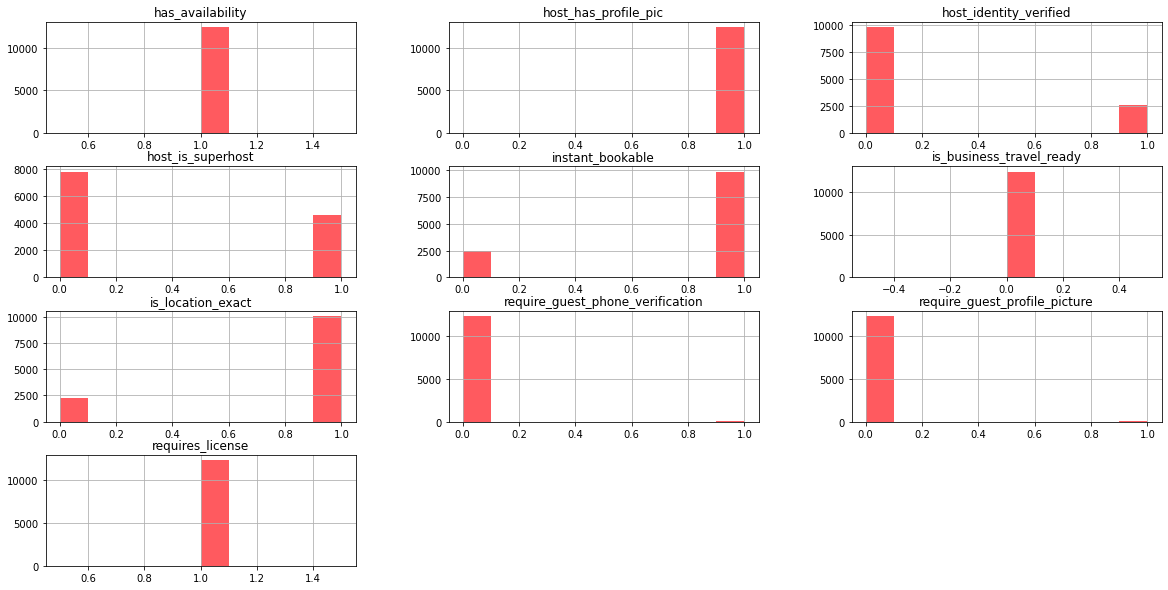

In [43]:
# Columns with only booleans for Verfication Purposes:
listing[['host_is_superhost',
         'host_has_profile_pic', 
         'host_identity_verified', 
         'require_guest_profile_picture',
         'require_guest_phone_verification',
         'requires_license', 
         'instant_bookable', 
         'is_business_travel_ready', 
         'is_location_exact',
         'has_availability'
        ]].hist(figsize=(20,10), color='#FF5A5F');

<div class="alert alert-block alert-success">

<b>Observation:</b>

As shown above some of the features showed uniform result. Hence will be dropping them as they will not be affect the price. 
- host_has_profile_pic
- is_business_travel_ready
- require_guest_phone_verification
- require_guest_profile_picture
- requires_license

</div>

In [44]:
listing.drop(['host_has_profile_pic',
              'is_business_travel_ready',
              'require_guest_phone_verification',
              'require_guest_profile_picture',
              'requires_license', 
              'has_availability'], axis=1, inplace=True)

In [45]:
# Convert the rest of the boolean to int 

listing.host_is_superhost = listing.host_is_superhost.astype('int64')
listing.host_identity_verified = listing.host_identity_verified.astype('int64')

##### c. Minimum and Maximum Nights

<div class="alert alert-block alert-success">

<b>Observation:</b>

There are multiple columns that are related to minimum and maximum night stays. To avoid overlapping of data, I will using the basic two which have not been altered.

</div>

In [46]:
listing.drop(['minimum_minimum_nights',
             'maximum_minimum_nights',
             'minimum_maximum_nights',
             'maximum_maximum_nights',
             'minimum_nights_avg_ntm',
             'maximum_nights_avg_ntm'], axis=1, inplace=True)

##### d. Categorical Columns

##### i. property_type

<div class="alert alert-block alert-success">

<b>Observation:</b>

There are a total of 29 unique property types with a majority being the Apartment. However other property types (e.g. house, condominium, serviced apartment) can be considered to be in the same category as well. 

</div>

In [47]:
print(listing.property_type.nunique())
listing.property_type.value_counts()

27


Apartment             7558
House                 2187
Hostel                 854
Condominium            418
Hotel                  283
Aparthotel             198
Boutique hotel         164
Villa                  140
Serviced apartment     135
Ryokan (Japan)         130
Loft                    49
Hut                     49
Guesthouse              44
Townhouse               34
Bed and breakfast       24
Guest suite             19
Tiny house              19
Other                   14
Cabin                    9
Bungalow                 5
Dome house               4
Nature lodge             4
Tent                     3
Camper/RV                1
Cottage                  1
Dorm                     1
Earth house              1
Name: property_type, dtype: int64

In [48]:
# # Regroup and rename property type
# listing.property_type.replace({
#     'Apartment': 'house',
#     'House': 'house',
#     'Hostel': 'hostel',
#     'Condominium': 'apartment', 
#     'Aparthotel': 'hotel', 
#     'Boutique hotel': 'hotel', 
#     'Villa': 'house', 
#     'Serviced apartment': 'apartment',
#     'Ryokan (Japan)': 'apartment',
#     'Hut': 'house',
#     'Loft': 'apartment',
#     'Guesthouse': 'house',
#     'Bed and breakfast': '',
#     'Townhouse': 'house',
#     'Guest suite': '',
#     'Tiny house': 'house',
#     'Other': '',
#     'Cabin': '',
#     'Dome house': 'house',
#     'Camper/RV': '',
#     'Bungalow': 'house',
#     'Tent': '',
#     'Nature lodge': 'house',
#     'Resort','house',
#     'Earth house','',
#     'Cottage','house',
#     'Castle','castle',
#     'Dorm','hostel'
#     }, inplace=True)

##### ii. room_type

In [49]:
listing.room_type.value_counts()

Entire home/apt    8804
Private room       2469
Hotel room          588
Shared room         487
Name: room_type, dtype: int64

In [50]:
# Rename room type
listing.room_type.replace({
    'Entire home/apt': 'entire_home_apt',
    'Private room': 'private_room',
    'Hotel room': 'hotel_room',
    'Shared room': 'shared_room',  
    }, inplace=True)

##### iii. bed_type

<div class="alert alert-block alert-success">

<b>Observation:</b>

This column seem kinda redundent since majority are the same bed. Hence will be dropping this column. 

</div>

In [51]:
listing.bed_type.value_counts()

Real Bed         12295
Futon               45
Pull-out Sofa        4
Airbed               3
Couch                1
Name: bed_type, dtype: int64

In [52]:
listing.drop(['bed_type'], axis=1, inplace=True)

##### iv. amenities

<div class="alert alert-block alert-success">

Amenities is a list of additional features in the property where i believe people look at before (e.g. wifi, air conditioning, swimming pool, etc), committing the booking. However not all amenities are of the same importance.

There are over 150 unique type of amenities

</div>

In [53]:
listing.amenities.head()

0    {TV,Internet,Wifi,Kitchen,"Paid parking off pr...
1    {TV,Internet,Wifi,"Air conditioning",Kitchen,"...
2    {TV,Wifi,"Air conditioning",Kitchen,"Hot tub",...
3    {TV,Internet,Wifi,"Air conditioning",Kitchen,"...
4    {TV,Internet,Wifi,"Air conditioning",Kitchen,"...
Name: amenities, dtype: object

In [54]:
listing['amenities'] = listing['amenities'].str.replace('{', '').str.replace('}','').str.replace('"', '')
listing['amenities'] = listing['amenities'].str.lower()

##### v. Calendar_updated

<div class="alert alert-block alert-warning">

<b>Observation:</b>

- to get back to this
- or else to be dropped

</div>

In [55]:
print("Total categories:", listing.calendar_updated.nunique())
print('')
print("Top 5 categories:")
listing.calendar_updated.value_counts()[:5]

Total categories: 42

Top 5 categories:


today           2443
2 months ago    1552
3 months ago    1332
yesterday        830
2 weeks ago      740
Name: calendar_updated, dtype: int64

##### vi. Availability

<div class="alert alert-block alert-warning">

<b>Observation:</b>

- to get back to this
- or else to be dropped

</div>

In [56]:
print("Avail 30days categories:", listing.availability_30.nunique())
print("Avail 60days categories:", listing.availability_60.nunique())
print("Avail 90days categories:", listing.availability_90.nunique())
print("Avail 365days categories:", listing.availability_365.nunique())
print('')
print("Top 5 categories of 30days:")
listing.availability_30.value_counts()[:5]

Avail 30days categories: 31
Avail 60days categories: 61
Avail 90days categories: 91
Avail 365days categories: 366

Top 5 categories of 30days:


0     3529
30    3331
29    1708
28     704
1      387
Name: availability_30, dtype: int64

##### vi. Cancellation Policy

In [57]:
listing.cancellation_policy.value_counts()

strict_14_with_grace_period    8327
moderate                       2622
flexible                       1367
strict                           15
super_strict_60                  13
super_strict_30                   4
Name: cancellation_policy, dtype: int64

In [58]:
listing.cancellation_policy.replace({
    'strict_14_with_grace_period': 'strict',
    'super_strict_30': 'super_strict',
    'super_strict_60': 'super_strict',
    'strict_14_with_grace_period': 'strict',
    'luxury_moderate': 'moderate'
    }, inplace=True)
listing.cancellation_policy.value_counts()

strict          8342
moderate        2622
flexible        1367
super_strict      17
Name: cancellation_policy, dtype: int64

In [59]:
print(listing.shape)

(12348, 44)


##### Save DataFrame

In [60]:
# listing.to_csv("../datasets/listing_cleaned.csv")

##### Merge Dataframe

In [61]:
# listing_cal = pd.merge(listing, calendar, how='left', on=['id', date','price'])

###  <span style='background:yellow'> 3.3. Neighbourhood </span>

In [62]:
neighbourhood = neighbourhood.drop(['neighbourhood_group'], axis=1)
neighbourhood

,neighbourhood
0,Adachi Ku
1,Akiruno Shi
2,Akishima Shi
3,Aogashima Mura
4,Arakawa Ku
...,...
57,Tachikawa Shi
58,Taito Ku
59,Tama Shi
60,Toshima Ku


<div class="alert alert-block alert-success">

<b>Observation:</b>
Since listing dataframe has the column on neighbourhood_cleansed and country code. This dataframe might not be required. 

</div>

##### Save DataFrame

In [63]:
neighbourhood.to_csv("../datasets/neighbourhood_cleaned.csv")

### <span style='background:yellow'> 3.4 Reviews </span>

In [64]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,35303,810980,2011-12-28,1502908,Firuz,Miyuki's has been a great host. Helpful and ve...
1,35303,2467161,2012-10-01,350719,Jordan,Nice apartment in one of the best areas of Tok...
2,35303,3572628,2013-02-18,4917704,Aymeric,A very nice host and place. The location is in...
3,35303,3952097,2013-03-30,3243253,Blandine,Miyuki is the most smily face I met when I lan...
4,35303,4377509,2013-05-01,1536097,Kayleigh,The location's wonderful. It's close to Haraju...


In [65]:
# Parse date-time string to datetime object
reviews.date = pd.to_datetime(reviews['date'])

In [66]:
# Drop Unneccessary Columns
reviews.drop(['id','reviewer_id','reviewer_name'], axis=1, inplace=True)

<div class="alert alert-block alert-success">

<b>Observation:</b>

In the comments column, there are languages other than english. RNN(?) 

</div>

##### Save DataFrame

In [67]:
# reviews.to_csv("../datasets/reviews_cleaned.csv")

##### Merge And Save Final Dataframe

In [68]:
# merge = pd.merge(listing_cal, reviews, how='left', on=['listing_id'])

In [ ]:
# merge.to_csv("../datasets/final.csv")

In [72]:
final = listing

## <span style='background:yellow'> 2. Full Exploratory Analysis </span> -- to be split into the next notebook

In [73]:
final.head().T

,0,1,2,3,4
id,35303,197677,289597,370759,700253
host_id,151977,964081,341577,1573631,341577
host_since,2010-06-25 00:00:00,2011-08-13 00:00:00,2011-01-10 00:00:00,2012-01-06 00:00:00,2011-01-10 00:00:00
host_response_time,unknown,within a few hours,within a few hours,within a day,within a few hours
host_response_rate,unknown,100%,100%,100%,100%
host_acceptance_rate,unknown,50-89%,50-89%,90-99%,50-89%
host_is_superhost,0,1,0,1,0
host_listings_count,3,1,2,3,2
host_identity_verified,1,1,1,1,1
neighbourhood_cleansed,Shibuya Ku,Sumida Ku,Nerima Ku,Setagaya Ku,Nerima Ku


##### Host

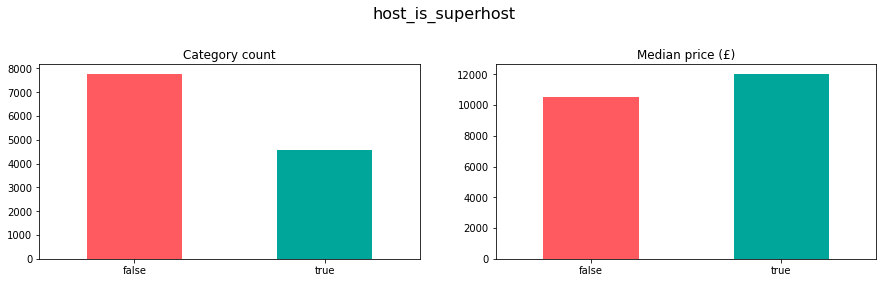

0    0.629738
1    0.370262
Name: host_is_superhost, dtype: float64


In [74]:
def binary_count_and_price_plot(col, figsize=(15,4)):
    """
    Plots a simple bar chart of the counts of true and false categories in the column specified,
    next to a bar chart of the median price for each category.
    A figure size can optionally be specified.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle(col, fontsize=16, y=1)
    plt.subplots_adjust(top=0.80) # So that the suptitle does not overlap with the ax plot titles
    
    final.groupby(col).size().plot(kind='bar', ax=ax1, color=['#FF5A5F', '#00A699'])
    ax1.set_xticklabels(labels=['false', 'true'], rotation=0)
    ax1.set_title('Category count')
    ax1.set_xlabel('')
    
    final.groupby(col).price.median().plot(kind='bar', ax=ax2, color=['#FF5A5F', '#00A699'])
    ax2.set_xticklabels(labels=['false', 'true'], rotation=0)
    ax2.set_title('Median price (£)')
    ax2.set_xlabel('')
    
    plt.show()

binary_count_and_price_plot('host_is_superhost')
print(final.host_is_superhost.value_counts(normalize=True));

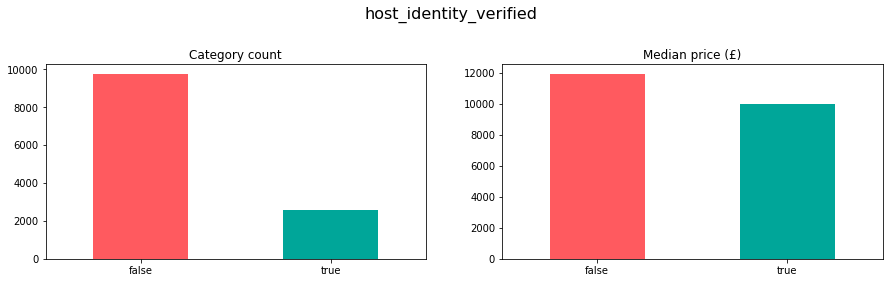

0    0.790735
1    0.209265
Name: host_identity_verified, dtype: float64


In [75]:
binary_count_and_price_plot('host_identity_verified')
print(final.host_identity_verified.value_counts(normalize=True));

##### Host Listing Count

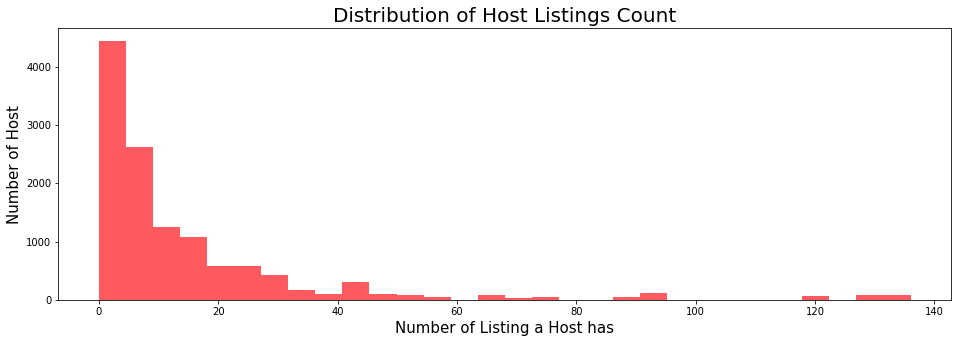

In [76]:
plt.figure(figsize=(16,5))
plt.hist(final['host_listings_count'], bins=30, color ='#FF5A5F')
plt.title('Distribution of Host Listings Count', fontsize=20)
plt.xlabel('Number of Listing a Host has', fontsize=15)
plt.ylabel('Number of Host', fontsize=15);

In [77]:
top_host=final.host_id.value_counts().head(10)
top_host

75820284     84
73463626     66
198552582    61
261951920    54
258668827    49
232836811    45
232445532    45
159375498    44
71735650     42
185778164    42
Name: host_id, dtype: int64

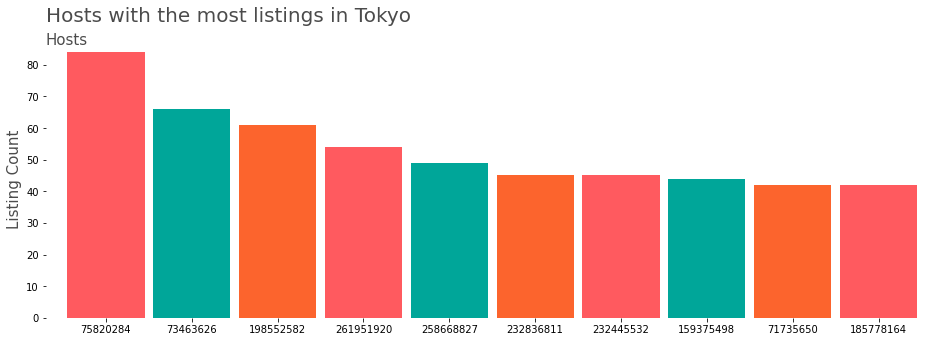

In [78]:
fig = plt.figure(1, figsize=(16,5))
ax = fig.add_subplot(111)

title = 'Hosts with the most listings in Tokyo'

transparency = 0.7
color = ['#FF5A5F', '#00A699', '#FC642D']

top_host.plot(kind = 'bar', 
              color = color, 
              width = 0.9,
              title = title)

ax.grid(False)
ax.set_frame_on(False)

ax.set_title(ax.get_title(), fontsize=20, alpha=transparency, ha='left')
plt.subplots_adjust(top=0.9)
ax.title.set_position((0,1.04))

ax.xaxis.set_label_position('top')
xlab = 'Hosts'
ax.set_xlabel(xlab, fontsize=15, alpha=transparency, ha='left')
ax.xaxis.set_label_coords(0, 0.98)
plt.xticks(rotation=0)

ylab = 'Listing Count'
ax.set_ylabel(ylab, fontsize=15, alpha=transparency);

# plt.tight_layout()
# plt.title('Hosts with the most listings in Tokyo', fontsize=20)
# plt.xlabel('Host IDs', fontsize=15)


<div class="alert alert-block alert-success">

<b>Observation:</b>

Most host does not have any listing, and some has over 100 listings?!


</div>

<div class="alert alert-block alert-warning">

<b>To Do:</b>

Remove Outlier:

- to drop host with zero listings
- to drop outrages number of listings

</div>

##### Neighbourhod

In [79]:
# Create new dataframe for neighbourhood count
neighbourhood_count = pd.DataFrame()
neighbourhood_count['total_hosts'] = final['neighbourhood_cleansed'].value_counts()

# Filter out neighbourhood with less than 20 listings
neighbourhood_count = neighbourhood_count[neighbourhood_count['total_hosts'] > 20]

neighbourhood_count.sort_index(ascending=True, inplace=True)

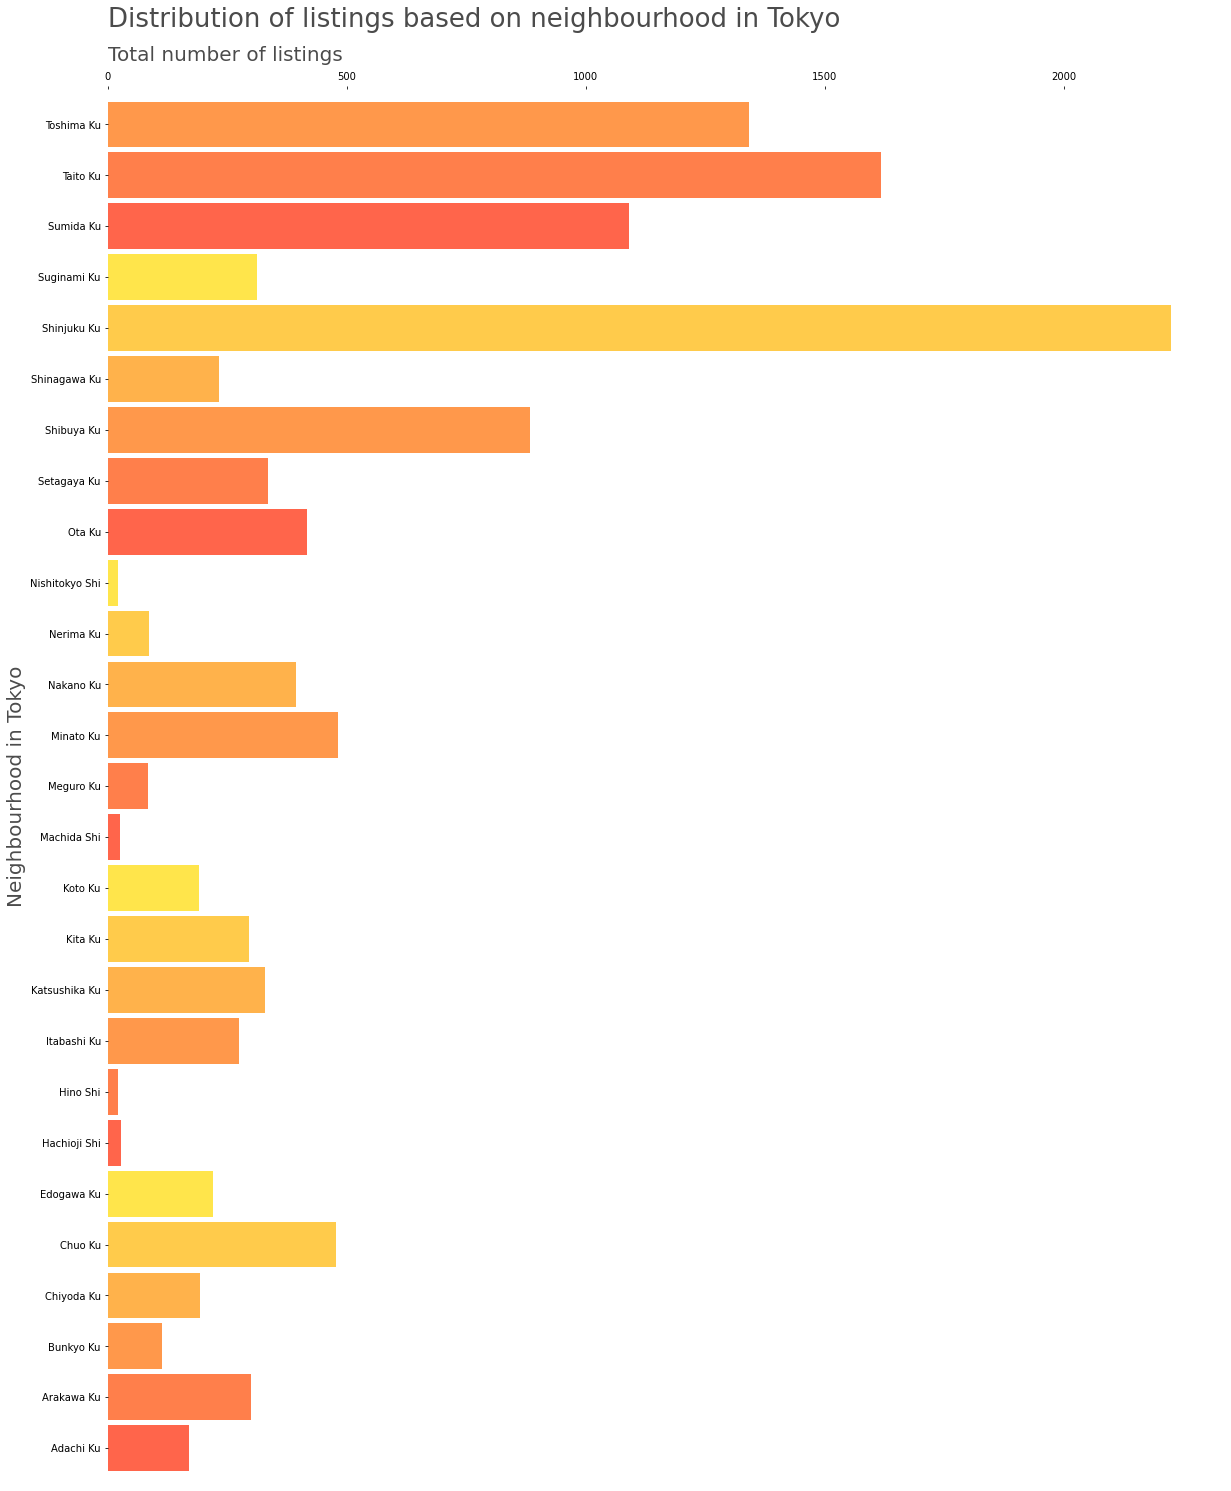

In [80]:
fig = plt.figure(1, figsize=(20,25))
ax = fig.add_subplot(111)

title="Distribution of listings based on neighbourhood in Tokyo"

transparency = 0.7
cmap = sns.color_palette("autumn")

neighbourhood_count['total_hosts'].plot(kind = 'barh',
                                        ax = ax,
                                        alpha = transparency,
                                        color = cmap,
                                        title = title, 
                                        width = 0.9)

ax.grid(False)
ax.set_frame_on(False)

ax.set_title(ax.get_title(), fontsize=26, alpha=transparency, ha='left')
plt.subplots_adjust(top=0.9)
ax.title.set_position((0,1.04))

ax.xaxis.set_label_position('top')
xlab = 'Total number of listings'
ax.set_xlabel(xlab, fontsize=20, alpha=transparency, ha='left')
ax.xaxis.set_label_coords(0, 1.02)
ax.xaxis.tick_top()

ylab = 'Neighbourhood in Tokyo'
ax.set_ylabel(ylab, fontsize=20, alpha=transparency);

##### Property and Room Type

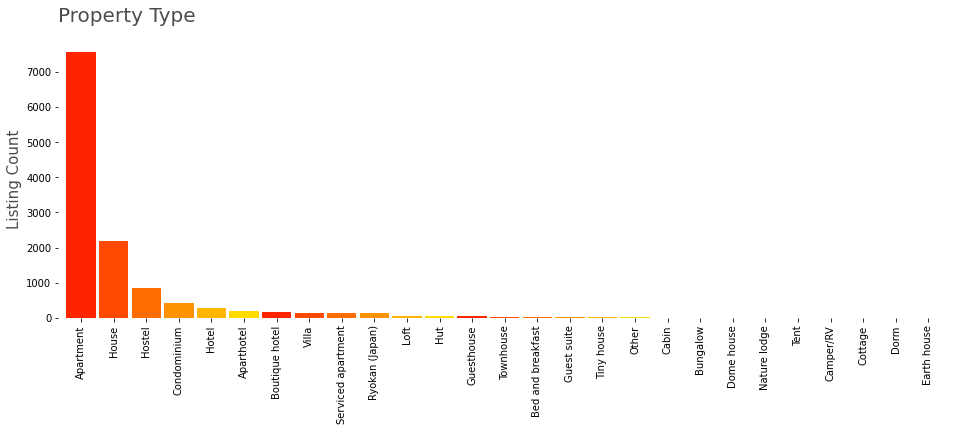

In [81]:
fig = plt.figure(1, figsize=(16,5))
ax = fig.add_subplot(111)

title = 'Property Type'

transparency = 0.7
color = sns.color_palette("autumn")

final['property_type'].value_counts().plot(kind='bar', 
                                             color = color, 
                                             width = 0.9, 
                                             title = title)

ax.grid(False)
ax.set_frame_on(False)

ax.set_title(ax.get_title(), fontsize=20, alpha=transparency, ha='left')
plt.subplots_adjust(top=0.9)
ax.title.set_position((0,1.04))

ylab = 'Listing Count'
ax.set_ylabel(ylab, fontsize=15, alpha=transparency);

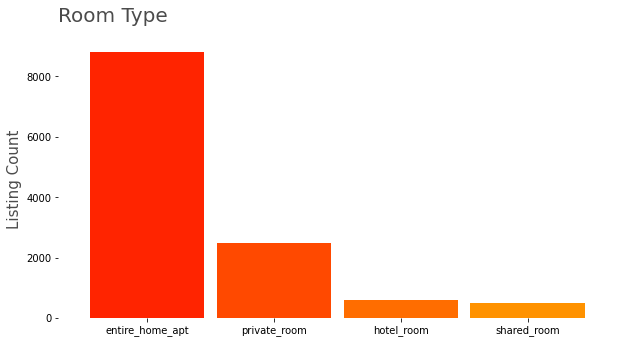

In [82]:
fig = plt.figure(1, figsize=(10,5))
ax = fig.add_subplot(111)

title = 'Room Type'

transparency = 0.7
color = sns.color_palette("autumn")

final['room_type'].value_counts().plot(kind='bar', 
                                             color = color, 
                                             width = 0.9, 
                                             title = title)

ax.grid(False)
ax.set_frame_on(False)

ax.set_title(ax.get_title(), fontsize=20, alpha=transparency, ha='left')
plt.subplots_adjust(top=0.9)
ax.title.set_position((0,1.04))
plt.xticks(rotation=0)

ylab = 'Listing Count'
ax.set_ylabel(ylab, fontsize=15, alpha=transparency);

##### Accomodates

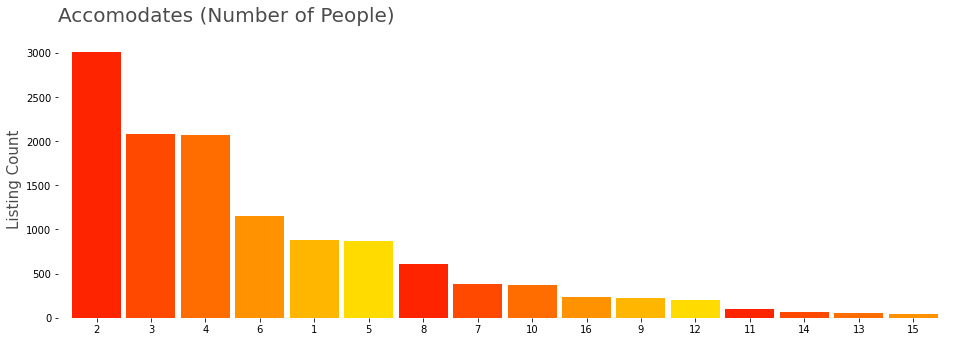

In [83]:
fig = plt.figure(1, figsize=(16,5))
ax = fig.add_subplot(111)

title = 'Accomodates (Number of People)'

transparency = 0.7
color = sns.color_palette("autumn")

final['accommodates'].value_counts().plot(kind='bar', 
                                             color = color, 
                                             width = 0.9, 
                                             title = title)

ax.grid(False)
ax.set_frame_on(False)

ax.set_title(ax.get_title(), fontsize=20, alpha=transparency, ha='left')
plt.subplots_adjust(top=0.9)
ax.title.set_position((0,1.04))
plt.xticks(rotation=0)

ylab = 'Listing Count'
ax.set_ylabel(ylab, fontsize=15, alpha=transparency);

##### Rooms

##### Price

In [84]:
pd.set_option('display.float_format', '{:.2f}'.format)
final.price.describe()

count     12348.00
mean      25066.75
std       73004.47
min           0.00
25%        6793.00
50%       10998.00
75%       19995.00
max     1000040.00
Name: price, dtype: float64

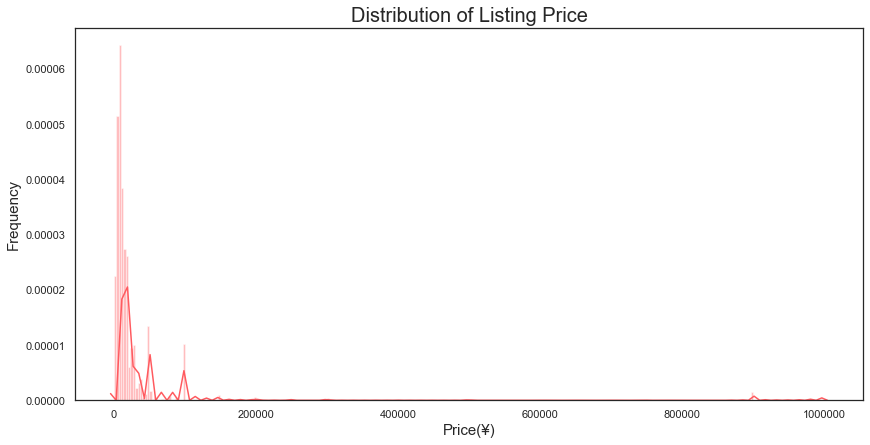

In [103]:
plt.figure(figsize =(12,6))
sns.distplot(final['price'], kde= True, bins=300, color ='#FF5A5F')
plt.ticklabel_format(style='plain', axis='y')
plt.ticklabel_format(style='plain', axis='x')
plt.tight_layout()
plt.ylabel('Frequency', fontsize=15)
plt.xlabel('Price(¥)', fontsize=15)
plt.title('Distribution of Listing Price', fontsize = 20);

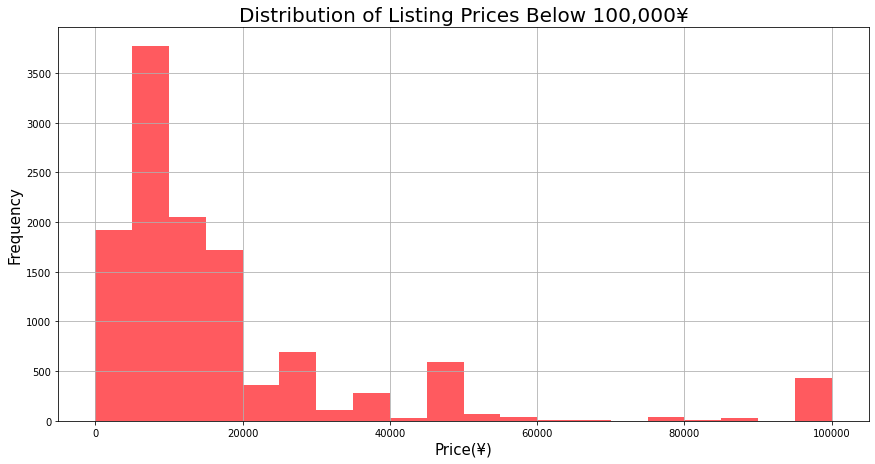

In [86]:
plt.figure(figsize =(12,6))
final['price'].hist(bins=[0,5000,10000,15000,20000,25000,30000,35000,40000,45000,50000,55000,
                           60000,65000,70000,75000,80000,85000,90000,95000,100000], color ='#FF5A5F')
plt.tight_layout()
plt.title('Distribution of Listing Prices Below 100,000¥', fontsize=20)
plt.xlabel('Price(¥)', fontsize=15)
plt.ylabel('Frequency', fontsize=15);

In [87]:
final[final['price'] == 0]
final[final['price'] > 100000].sort_values(by='price', ascending=False)

,id,host_id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_identity_verified,neighbourhood_cleansed,...,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,time_since_first_review
4715,28502660,215140194,2018-09-13,within an hour,100%,100%,0,5,0,Shibuya Ku,...,100%,10,10,10,10,10,10,1,moderate,0 days
7872,34131770,255944040,2019-04-15,within an hour,100%,100%,0,1,0,Shibuya Ku,...,50-89%,8,8,9,9,9,8,1,strict,326 days
11168,39568514,300897462,2019-10-08,within an hour,100%,100%,1,2,1,Shibuya Ku,...,90-99%,10,10,10,10,9,9,1,strict,178 days
5815,30536245,229126645,2018-12-04,unknown,unknown,100%,0,1,0,Minato Ku,...,90-99%,10,9,10,10,9,9,1,strict,350 days
11579,40026354,150082965,2017-09-11,within an hour,100%,90-99%,0,6,0,Toshima Ku,...,50-89%,9,10,9,9,9,9,1,moderate,140 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9429,36993816,215606612,2018-09-16,within an hour,100%,100%,0,42,0,Toshima Ku,...,90-99%,10,10,9,9,10,9,1,strict,198 days
9431,36994756,215606612,2018-09-16,within an hour,100%,100%,0,42,0,Toshima Ku,...,90-99%,10,10,9,9,10,10,1,strict,225 days
313,7620544,39969626,2015-07-29,unknown,unknown,100%,1,3,1,Adachi Ku,...,90-99%,10,10,10,10,9,10,1,moderate,643 days
5529,30023363,208133335,2018-08-07,within a few hours,100%,100%,1,3,0,Shinjuku Ku,...,100%,10,10,10,10,10,8,1,strict,0 days


In [88]:
top_neighbourhood = final.neighbourhood_cleansed.value_counts().head()
top_neighbourhood

Shinjuku Ku    2224
Taito Ku       1618
Toshima Ku     1342
Sumida Ku      1091
Shibuya Ku      883
Name: neighbourhood_cleansed, dtype: int64

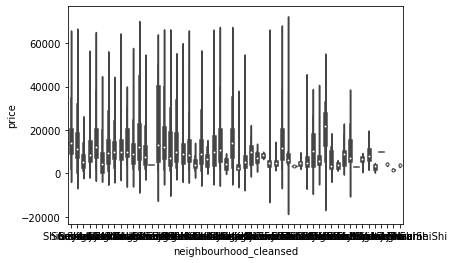

In [89]:
#creating a sub-dataframe with no extreme values / less than 500

data = final[final.price < 60_000]

#using violinplot to showcase density and distribtuion of prices 
sns.violinplot(data=data , x='neighbourhood_cleansed', y='price');

<div class="alert alert-block alert-success">

<b>Observation:</b>

There seem to have listing that are of zero value. On top of that, there are listing that are listed at outrages price

</div>

<div class="alert alert-block alert-warning">

<b>To Do:</b>

Remove Outlier:

- to drop prices that are priced at zero 
- to drop outrages price listings

</div>

##### Review_Scores

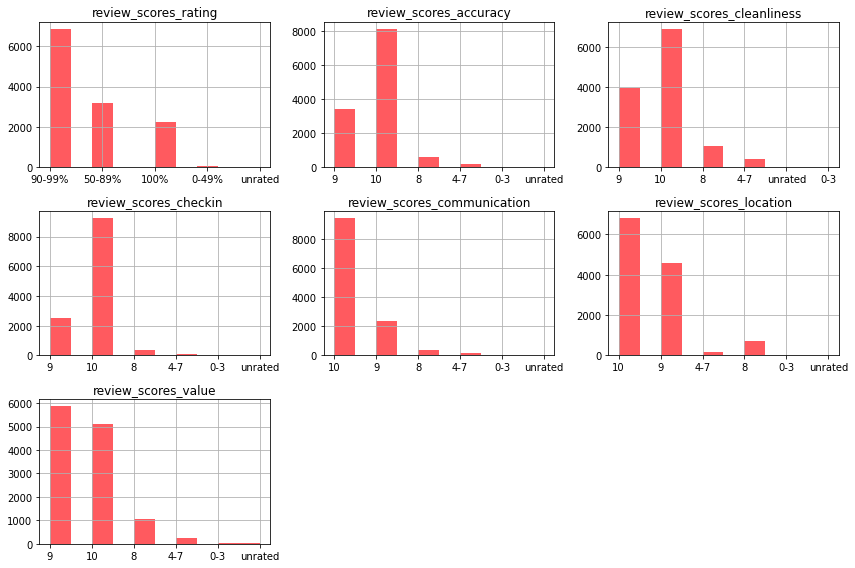

In [90]:
review_col = list(final.columns[final.columns.str.startswith("review_scores") == True])

fig = plt.figure(figsize=(12,8))
for i, var_name in enumerate(review_col):
    ax = fig.add_subplot(3,3,i+1)
    final[var_name].hist(bins=10, ax=ax, color = '#FF5A5F')
    ax.set_title(var_name)
    
fig.tight_layout()

## 3. Time Series Analysis

##### a. Time Since First Review

In [91]:
# final['time_since_first_review'] = final.last_review - final.first_review
# final.time_since_first_review.hist(figsize=(11,9), bins=30);

##### a. Heatmap

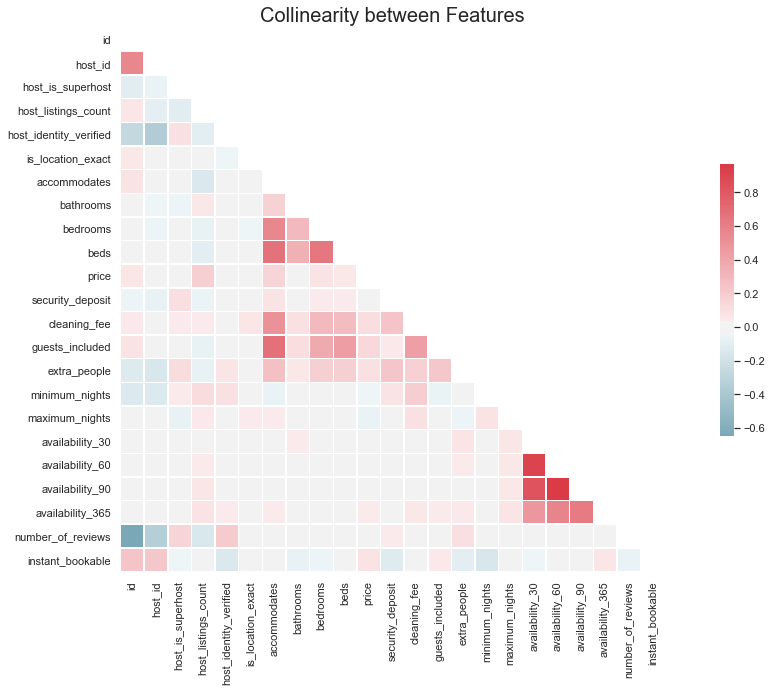

In [92]:
sns.set(style="white")

corr = final.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(20,10))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, 
            mask=mask, 
            cmap=cmap, 
            center=0, 
            square=True, 
            linewidths=.5, 
            cbar_kws={"shrink": .5}, 
            vmax=corr[corr != 1.0].max().max())

ax.set_title('Collinearity between Features', fontsize=20);

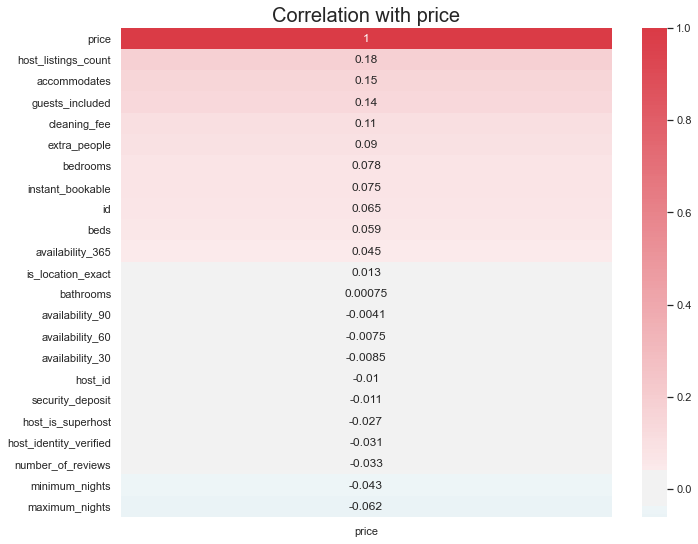

In [93]:
fig = plt.figure(figsize=(11,9))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(final.corr()[['price']].sort_values(by='price', ascending=False), 
            cmap=cmap, 
            center=0, 
            annot=True)

plt.title('Correlation with price', fontsize=20)
y_min, y_max = ax.get_ylim() 
x_min, x_max = ax.get_xlim()
ax.set_ylim(top=y_max+1) 
ax.set_xlim(right=x_max-1);

<div class="alert alert-block alert-warning">

<b>EDA PLOTS:</b> 

1. Distribution of Review scores 

2. Distribution of listings based on neighbourhood in Tokyo
    - total number of listing (y-axis)
    - neighbourhood in Tokyo (x-axis)
    
3. Popularity of room types in property types

4. see if there is any trend on bookings? (seasonality)

5. listings per host

6. property, room type on price
    

</div>

### <span style='background:yellow'> 5. Feature Engineering </span> 

##### a. Categorical Variables

In [ ]:
# final = pd.get_dummies(final, columns=['property_type',
#                                            'room_type',
#                                            'cancellation_policy', 
#                                            'neighbourhood_cleansed',
#                                            'host_response_time'], 
#                          drop_first = False)
# final.shape

##### b. Amenities

In [ ]:
all_amenities = final['amenities'].str.get_dummies(sep=',')

In [ ]:
all_amenities = pd.concat([final.price, all_amenities], axis=1)

In [ ]:
all_amenities.head()

In [ ]:
sns.set(style="white")

corr = all_amenities.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(20,20))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, 
            mask=mask, 
            cmap=cmap, 
            center=0, 
            square=True, 
            linewidths=.5, 
            cbar_kws={"shrink": .5}, 
            vmax=corr[corr != 1.0].max().max());

ax.set_title('Collinearity between Amenities', fontsize=20);